In [1]:

import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
!nvidia-smi

Thu Jun 10 14:15:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P3    N/A /  N/A |      7MiB /  4040MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [5]:
# !pip install imutils

In [6]:
import h5py

x = h5py.File('set_x.h5', 'r')['x'][:]
y = h5py.File('set_y.h5', 'r')['y'][:].reshape((-1,1))

In [7]:
y

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

In [8]:
x.shape, y.shape

((2342, 256, 256, 3), (2342, 1))

In [9]:
import cv2
import numpy as np
new_x = []
for i in range(x.shape[0]):
    new_x.append(cv2.resize(x[i], (224, 224)))
x = np.array(new_x)
x.shape

(2342, 224, 224, 3)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [11]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

/home/mykola/anaconda3/envs/nets/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [42]:
y_train_enc = np.array([[1-i, i] for i in y_train]).reshape((-1,2))
y_test_enc = np.array([[1-i, i] for i in y_test]).reshape((-1,2))

In [43]:
y_train_enc.shape, y_test_enc.shape

((1569, 2), (773, 2))

In [44]:
y_train_enc

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

In [13]:
y_train_enc

array([0, 0, 1, ..., 0, 1, 1])

In [26]:
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [27]:

resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights('model.h5')
resnet_simclr.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

In [55]:
def plot_training(H):
	with plt.xkcd():
# 		plt.plot(H.history["loss"], label="train_loss")
# 		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [46]:

def get_linear_model(features):
    linear_model = Sequential([Dense(2, input_shape=(features, ), activation="softmax")])
    return linear_model

In [47]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

In [57]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-1].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1569, 50) (773, 50)


In [58]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1500, verbose=2, restore_best_weights=True)

In [59]:
# !pip install 'gast==0.2.2'

In [60]:
train_features.shape

(1569, 50)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 2)                 102       
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________
Train on 1569 samples, validate on 773 samples
Epoch 1/500
1569/1569 [==============================] - 0s 204us/sample - loss: 482.8148 - accuracy: 0.5099 - val_loss: 163.6266 - val_accuracy: 0.5097
Epoch 2/500
1569/1569 [==============================] - 0s 41us/sample - loss: 52.4809 - accuracy: 0.5054 - val_loss: 30.8903 - val_accuracy: 0.5097
Epoch 3/500
1569/1569 [==============================] - 0s 43us/sample - loss: 10.6659 - accuracy: 0.4952 - val_loss: 1.4569 - val_accuracy: 0.4838
Epoch 4/500
1569/1569 [==============================] - 0s 40us/sample - loss: 1.8188 - accuracy: 0.5054 - val_loss: 1.4715 - val_accuracy: 0.4799
Epo

1569/1569 [==============================] - 0s 41us/sample - loss: 1.2849 - accuracy: 0.5526 - val_loss: 1.4648 - val_accuracy: 0.5356
Epoch 53/500
1569/1569 [==============================] - 0s 42us/sample - loss: 1.2444 - accuracy: 0.5800 - val_loss: 1.2883 - val_accuracy: 0.5576
Epoch 54/500
1569/1569 [==============================] - 0s 41us/sample - loss: 1.2396 - accuracy: 0.5870 - val_loss: 1.3216 - val_accuracy: 0.5537
Epoch 55/500
1569/1569 [==============================] - 0s 41us/sample - loss: 1.5736 - accuracy: 0.5507 - val_loss: 1.4241 - val_accuracy: 0.5459
Epoch 56/500
1569/1569 [==============================] - 0s 42us/sample - loss: 1.5574 - accuracy: 0.5481 - val_loss: 1.6676 - val_accuracy: 0.5278
Epoch 57/500
1569/1569 [==============================] - 0s 47us/sample - loss: 1.2106 - accuracy: 0.5902 - val_loss: 1.8041 - val_accuracy: 0.5291
Epoch 58/500
1569/1569 [==============================] - 0s 49us/sample - loss: 1.5547 - accuracy: 0.5532 - val_loss: 

1569/1569 [==============================] - 0s 41us/sample - loss: 1.0426 - accuracy: 0.6189 - val_loss: 1.1609 - val_accuracy: 0.6184
Epoch 108/500
1569/1569 [==============================] - 0s 42us/sample - loss: 0.9213 - accuracy: 0.6526 - val_loss: 1.1468 - val_accuracy: 0.5550
Epoch 109/500
1569/1569 [==============================] - 0s 45us/sample - loss: 1.3019 - accuracy: 0.5736 - val_loss: 1.4110 - val_accuracy: 0.5097
Epoch 110/500
1569/1569 [==============================] - 0s 50us/sample - loss: 1.3627 - accuracy: 0.5692 - val_loss: 0.9431 - val_accuracy: 0.6624
Epoch 111/500
1569/1569 [==============================] - 0s 47us/sample - loss: 1.2992 - accuracy: 0.5711 - val_loss: 1.0899 - val_accuracy: 0.6352
Epoch 112/500
1569/1569 [==============================] - 0s 40us/sample - loss: 1.0163 - accuracy: 0.6335 - val_loss: 1.4751 - val_accuracy: 0.5045
Epoch 113/500
1569/1569 [==============================] - 0s 43us/sample - loss: 1.0166 - accuracy: 0.6233 - val_

Epoch 162/500
1569/1569 [==============================] - 0s 44us/sample - loss: 0.8263 - accuracy: 0.6864 - val_loss: 0.9142 - val_accuracy: 0.6313
Epoch 163/500
1569/1569 [==============================] - 0s 41us/sample - loss: 0.8964 - accuracy: 0.6495 - val_loss: 0.9378 - val_accuracy: 0.6184
Epoch 164/500
1569/1569 [==============================] - 0s 40us/sample - loss: 1.1535 - accuracy: 0.5819 - val_loss: 2.4073 - val_accuracy: 0.5084
Epoch 165/500
1569/1569 [==============================] - 0s 41us/sample - loss: 1.4734 - accuracy: 0.5800 - val_loss: 1.4256 - val_accuracy: 0.5045
Epoch 166/500
1569/1569 [==============================] - 0s 44us/sample - loss: 1.1634 - accuracy: 0.5985 - val_loss: 0.9036 - val_accuracy: 0.6352
Epoch 167/500
1569/1569 [==============================] - 0s 47us/sample - loss: 0.9458 - accuracy: 0.6373 - val_loss: 1.7412 - val_accuracy: 0.5278
Epoch 168/500
1569/1569 [==============================] - 0s 42us/sample - loss: 1.6227 - accuracy:

1569/1569 [==============================] - 0s 42us/sample - loss: 0.7923 - accuracy: 0.6781 - val_loss: 0.9690 - val_accuracy: 0.5705
Epoch 217/500
1569/1569 [==============================] - 0s 44us/sample - loss: 1.9508 - accuracy: 0.5641 - val_loss: 4.4231 - val_accuracy: 0.5097
Epoch 218/500
1569/1569 [==============================] - 0s 42us/sample - loss: 2.8682 - accuracy: 0.5207 - val_loss: 2.8678 - val_accuracy: 0.4838
Epoch 219/500
1569/1569 [==============================] - 0s 39us/sample - loss: 0.9888 - accuracy: 0.6501 - val_loss: 0.9784 - val_accuracy: 0.5640
Epoch 220/500
1569/1569 [==============================] - 0s 42us/sample - loss: 0.7962 - accuracy: 0.6788 - val_loss: 0.8162 - val_accuracy: 0.6999
Epoch 221/500
1569/1569 [==============================] - 0s 41us/sample - loss: 0.9801 - accuracy: 0.6412 - val_loss: 1.1793 - val_accuracy: 0.5912
Epoch 222/500
1569/1569 [==============================] - 0s 44us/sample - loss: 0.8645 - accuracy: 0.6488 - val_

Epoch 271/500
1569/1569 [==============================] - 0s 41us/sample - loss: 0.8118 - accuracy: 0.6826 - val_loss: 0.8848 - val_accuracy: 0.6727
Epoch 272/500
1569/1569 [==============================] - 0s 37us/sample - loss: 0.9223 - accuracy: 0.6221 - val_loss: 0.7433 - val_accuracy: 0.7180
Epoch 273/500
1569/1569 [==============================] - 0s 41us/sample - loss: 0.9999 - accuracy: 0.6424 - val_loss: 0.9421 - val_accuracy: 0.6481
Epoch 274/500
1569/1569 [==============================] - 0s 44us/sample - loss: 1.0946 - accuracy: 0.6074 - val_loss: 0.8363 - val_accuracy: 0.6843
Epoch 275/500
1569/1569 [==============================] - 0s 41us/sample - loss: 0.7676 - accuracy: 0.6915 - val_loss: 0.9105 - val_accuracy: 0.5783
Epoch 276/500
1569/1569 [==============================] - 0s 40us/sample - loss: 1.0875 - accuracy: 0.6055 - val_loss: 1.0327 - val_accuracy: 0.5343
Epoch 277/500
1569/1569 [==============================] - 0s 44us/sample - loss: 1.1747 - accuracy:

1569/1569 [==============================] - 0s 41us/sample - loss: 1.1554 - accuracy: 0.5844 - val_loss: 0.7314 - val_accuracy: 0.7180
Epoch 326/500
1569/1569 [==============================] - 0s 42us/sample - loss: 0.8036 - accuracy: 0.6756 - val_loss: 0.7590 - val_accuracy: 0.7025
Epoch 327/500
1569/1569 [==============================] - 0s 42us/sample - loss: 0.7910 - accuracy: 0.6909 - val_loss: 0.7300 - val_accuracy: 0.7180
Epoch 328/500
1569/1569 [==============================] - 0s 41us/sample - loss: 1.4186 - accuracy: 0.5685 - val_loss: 0.8323 - val_accuracy: 0.6779
Epoch 329/500
1569/1569 [==============================] - 0s 38us/sample - loss: 1.2050 - accuracy: 0.6061 - val_loss: 1.1259 - val_accuracy: 0.5847
Epoch 330/500
1569/1569 [==============================] - 0s 43us/sample - loss: 1.4111 - accuracy: 0.5653 - val_loss: 1.8341 - val_accuracy: 0.4851
Epoch 331/500
1569/1569 [==============================] - 0s 41us/sample - loss: 1.2898 - accuracy: 0.5997 - val_

Epoch 380/500
1569/1569 [==============================] - 0s 41us/sample - loss: 0.8631 - accuracy: 0.6558 - val_loss: 1.8271 - val_accuracy: 0.5097
Epoch 381/500
1569/1569 [==============================] - 0s 38us/sample - loss: 1.8435 - accuracy: 0.5577 - val_loss: 1.2332 - val_accuracy: 0.5136
Epoch 382/500
1569/1569 [==============================] - 0s 39us/sample - loss: 0.9185 - accuracy: 0.6272 - val_loss: 0.8223 - val_accuracy: 0.6158
Epoch 383/500
1569/1569 [==============================] - 0s 37us/sample - loss: 1.1666 - accuracy: 0.5921 - val_loss: 0.6983 - val_accuracy: 0.7348
Epoch 384/500
1569/1569 [==============================] - 0s 40us/sample - loss: 0.7816 - accuracy: 0.6616 - val_loss: 0.6741 - val_accuracy: 0.7426
Epoch 385/500
1569/1569 [==============================] - 0s 39us/sample - loss: 0.8839 - accuracy: 0.6246 - val_loss: 1.1126 - val_accuracy: 0.5770
Epoch 386/500
1569/1569 [==============================] - 0s 41us/sample - loss: 1.7288 - accuracy:

1569/1569 [==============================] - 0s 43us/sample - loss: 0.7014 - accuracy: 0.7081 - val_loss: 0.8998 - val_accuracy: 0.5576
Epoch 435/500
1569/1569 [==============================] - 0s 40us/sample - loss: 0.8396 - accuracy: 0.6507 - val_loss: 0.7095 - val_accuracy: 0.6882
Epoch 436/500
1569/1569 [==============================] - 0s 41us/sample - loss: 0.7755 - accuracy: 0.6711 - val_loss: 2.2781 - val_accuracy: 0.4825
Epoch 437/500
1569/1569 [==============================] - 0s 43us/sample - loss: 1.6340 - accuracy: 0.5347 - val_loss: 2.8946 - val_accuracy: 0.4812
Epoch 438/500
1569/1569 [==============================] - 0s 39us/sample - loss: 1.6240 - accuracy: 0.5609 - val_loss: 0.6889 - val_accuracy: 0.7063
Epoch 439/500
1569/1569 [==============================] - 0s 40us/sample - loss: 0.8279 - accuracy: 0.6679 - val_loss: 0.6711 - val_accuracy: 0.7348
Epoch 440/500
1569/1569 [==============================] - 0s 40us/sample - loss: 0.6866 - accuracy: 0.7017 - val_

Epoch 489/500
1569/1569 [==============================] - 0s 41us/sample - loss: 1.6366 - accuracy: 0.5022 - val_loss: 2.0430 - val_accuracy: 0.5097
Epoch 490/500
1569/1569 [==============================] - 0s 37us/sample - loss: 1.0399 - accuracy: 0.5934 - val_loss: 1.8700 - val_accuracy: 0.4825
Epoch 491/500
1569/1569 [==============================] - 0s 40us/sample - loss: 0.9568 - accuracy: 0.6259 - val_loss: 0.7141 - val_accuracy: 0.7167
Epoch 492/500
1569/1569 [==============================] - 0s 40us/sample - loss: 0.7285 - accuracy: 0.6966 - val_loss: 0.6589 - val_accuracy: 0.7400
Epoch 493/500
1569/1569 [==============================] - 0s 43us/sample - loss: 0.8297 - accuracy: 0.6571 - val_loss: 1.7744 - val_accuracy: 0.4838
Epoch 494/500
1569/1569 [==============================] - 0s 45us/sample - loss: 0.9238 - accuracy: 0.6520 - val_loss: 1.4279 - val_accuracy: 0.4903
Epoch 495/500
1569/1569 [==============================] - 0s 39us/sample - loss: 0.8761 - accuracy:

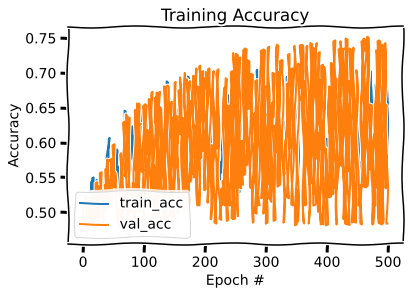

In [62]:
linear_model = get_linear_model(50)
linear_model.summary()
linear_model.compile(loss="categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=500,
                 callbacks=[es])
plot_training(history)

In [64]:
X_train.shape

(1569, 224, 224, 3)

In [68]:
train_features.shape

(1569, 128)

In [71]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=1000).fit(train_features, y_train)

/home/mykola/anaconda3/envs/nets/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [73]:
clf.score(test_features, y_test)

0.7736093143596378